In [1]:
# Import necessary modules and Pipeline
import pandas as pd
import matplotlib.pyplot as plt
from pipeline import Pipeline
from sklearn.metrics import ndcg_score
import numpy as np

In [2]:
# Load Dataset Paths
ratings_file = '/teamspace/studios/this_studio/u.data'
metadata_file = '/teamspace/studios/this_studio/u.item'
user_info_file = '/teamspace/studios/this_studio/u.user'

# Load Additional Metadata
# Load movie metadata
metadata = pd.read_csv(metadata_file, sep='|', encoding='latin-1', names=[
    'item', 'title', 'release_date', 'video_release_date', 'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation',
    'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery',
    'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'
])

# Load user demographic information
user_info = pd.read_csv(user_info_file, sep='|', names=['user', 'age', 'gender', 'occupation', 'zip'])

# Load ratings data
ratings = pd.read_csv(ratings_file, sep='\t', names=['user', 'item', 'rating', 'timestamp'])

In [3]:
# Load Dataset Using Pipeline
pipeline = Pipeline()
pipeline.load_dataset(ratings_file)

# Partition the data into training and testing sets
train_df, test_df = pipeline.partition_data(partition_type='user_stratified')

# Initialize the models using Pipeline
pipeline.initialize_models(ratings_file=ratings_file, metadata_file=metadata_file)

# Fit all models using Pipeline's fit_models function
pipeline.fit_models()

# Evaluate models after training to establish baseline performance
pipeline.evaluate_models()

Dataset loaded with shape: (100000, 4)
   user_id  item_id  rating  timestamp
0      196      242       3  881250949
1      186      302       3  891717742
2       22      377       1  878887116
3      244       51       2  880606923
4      166      346       1  886397596
Training set shape: (79734, 4)
Testing set shape: (20266, 4)
RMSE: 0.9362
Collaborative Filtering Model RMSE: 0.9362309162270313
Content-Based Filtering Model RMSE: 1.770201401084926


In [4]:
# Cold Start Scenarios

# Scenario 1: New User with No Ratings
print("\nSimulating Cold Start Scenario: New User with No Ratings...")
# Select a user from the test set who is not in the training set
new_user_id = test_df['user_id'].iloc[0]  # Pick the first user from the test set

# Get Recommendations for New User with No Ratings using Rule-Based and Hybrid Recommendations
print("\nRecommendations for New User with No Ratings (Rule-Based and Hybrid Recommendations):")
pipeline.get_recommendations(user_id=new_user_id, top_n=10)


Simulating Cold Start Scenario: New User with No Ratings...

Recommendations for New User with No Ratings (Rule-Based and Hybrid Recommendations):
   item     score
0    56  4.813048
1    98  4.808753
2   408  4.729026
3   175  4.627795
4   187  4.595395
5   134  4.592303
6   185  4.592078
7   173  4.536520
8   646  4.536122
9    23  4.526568


In [5]:
# Scenario 2: New User with Very Few Ratings
print("\nSimulating Cold Start Scenario: New User with Few Ratings...")
new_user_few_ratings = {1: 4, 5: 3, 7: 5}  # Ratings provided by the new user

# Adding new user's ratings to the dataset and updating train set
new_user_ratings_df = pd.DataFrame([{'user_id': new_user_id, 'item_id': item_id, 'rating': rating, 'timestamp': 0}
                                    for item_id, rating in new_user_few_ratings.items()])
train_df = pd.concat([train_df, new_user_ratings_df], ignore_index=True)

# Re-fit models after adding new user's ratings
pipeline.ratings_df = train_df
pipeline.fit_models()

# Predict a rating for the new user on an item using Collaborative Filtering
print("\nEvaluating New User with Few Ratings...")
prediction = pipeline.collaborative_model.model.predict(new_user_id, 10)  # Predict rating for item 10
print(f"Predicted Rating for New User (Few Ratings) on Item 10: {prediction.est}")


Simulating Cold Start Scenario: New User with Few Ratings...

Evaluating New User with Few Ratings...
Predicted Rating for New User (Few Ratings) on Item 10: 4.075935971158545


In [6]:
# Strategies to Mitigate Cold Start

# Strategy 1: Rule-Based Recommendations for New Users
print("Top 5 Movies Recommended using Rule-Based Recommendations:")
top_movies = pipeline.recommender.rank_items(new_user_id, top_n=5)

# Handle whether `top_movies` is a DataFrame or a list
if isinstance(top_movies, pd.DataFrame):
    if 'item_id' in top_movies.columns:
        rule_based_items = top_movies['item_id'].tolist()
    elif 'item' in top_movies.columns:
        rule_based_items = top_movies['item'].tolist()
    else:
        raise KeyError("Expected column 'item' or 'item_id' not found in `top_movies` DataFrame.")
else:
    rule_based_items = top_movies

# Merge with metadata to get movie titles
rule_based_titles = metadata[metadata['item'].isin(rule_based_items)][['item', 'title']]
print(rule_based_titles)

Top 5 Movies Recommended using Rule-Based Recommendations:
     item                  title
133   134    Citizen Kane (1941)
191   192     Raging Bull (1980)
284   285  Secrets & Lies (1996)
478   479         Vertigo (1958)
602   603     Rear Window (1954)


**Rule-Based Recommendations**:
- This approach was chosen for its simplicity and effectiveness. It recommends the most popular items to new users, ensuring that they receive high-quality content without needing historical interaction data.

In [7]:
# Strategy 2: Content-Based Filtering for New Users
print("\nTop 5 Movies Recommended using Content-Based Filtering:")
content_based_recommendations = pipeline.content_based_model.get_top_items(user_id=new_user_id, top_n=5)

if isinstance(content_based_recommendations, pd.DataFrame):
    content_based_items = content_based_recommendations['item'].tolist()
elif isinstance(content_based_recommendations, list):
    content_based_items = [item for item, _ in content_based_recommendations]
else:
    content_based_items = []

# Merge with metadata to get movie titles
content_based_titles = metadata[metadata['item'].isin(content_based_items)][['item', 'title']]
print(content_based_titles)


Top 5 Movies Recommended using Content-Based Filtering:
    item                               title
33    34         Doom Generation, The (1995)
44    45          Eat Drink Man Woman (1994)
46    47                      Ed Wood (1994)
64    65  What's Eating Gilbert Grape (1993)
92    93     Welcome to the Dollhouse (1995)


/teamspace/studios/this_studio/content_based.py:216: RuntimeWarning: invalid value encountered in scalar divide
  score = np.dot(user_profile, item_vector) / (


**Content-Based Filtering**:
- Content-based filtering attempts to address personalization by recommending items similar to those the user has shown interest in. Although challenging for new users, it serves as an important foundation for tailored recommendations once sufficient user data is available.

In [8]:
# Strategy 3: Hybrid Model Recommendations for New Users
print("\nHybrid Recommendations for New User:")
hybrid_recommendations = set(rule_based_items).union(content_based_items)

# Display the hybrid recommendations as a sorted list
hybrid_recommendations_list = sorted(hybrid_recommendations)
hybrid_titles = metadata[metadata['item'].isin(hybrid_recommendations_list)][['item', 'title']]
print(hybrid_titles)


Hybrid Recommendations for New User:
     item                               title
33     34         Doom Generation, The (1995)
44     45          Eat Drink Man Woman (1994)
46     47                      Ed Wood (1994)
64     65  What's Eating Gilbert Grape (1993)
92     93     Welcome to the Dollhouse (1995)
133   134                 Citizen Kane (1941)
191   192                  Raging Bull (1980)
284   285               Secrets & Lies (1996)
478   479                      Vertigo (1958)
602   603                  Rear Window (1954)


**Hybrid Model**:
- A hybrid strategy combines both popularity and personalization by leveraging rule-based and content-based elements. This combination aims to create a balanced recommendation, capturing both the benefits of global popularity and the specificity of user preferences.

In [9]:
# Strategy 4: Enhanced Demographic-Based Cold Start
print("\nStrategy 4: Enhanced Demographic-Based Cold Start...")
new_user_age = 25  # Simulate a new user's age
new_user_occupation = 'student'  # Simulate a new user's occupation

# Filter users based on similar age and occupation
similar_users = user_info[
    (user_info['age'] >= new_user_age - 5) & (user_info['age'] <= new_user_age + 5) &
    (user_info['occupation'] == new_user_occupation)
]

if not similar_users.empty:
    popular_items_for_age_occupation_group = ratings[ratings['user'].isin(similar_users['user'])]['item'].value_counts().head(5)
    demographic_items = popular_items_for_age_occupation_group.index.tolist()  # Extract the item IDs
    demographic_avg_rating = ratings[ratings['item'].isin(demographic_items)]['rating'].mean()
else:
    demographic_avg_rating = 3.0  # Default average if no similar users found

# Merge with metadata to get movie titles
demographic_titles = metadata[metadata['item'].isin(demographic_items)][['item', 'title']]
print("Top Movies for Similar Age and Occupation Group:")
print(demographic_titles)


Strategy 4: Enhanced Demographic-Based Cold Start...
Top Movies for Similar Age and Occupation Group:
     item                      title
49     50           Star Wars (1977)
180   181  Return of the Jedi (1983)
257   258             Contact (1997)
287   288              Scream (1996)
293   294           Liar Liar (1997)


**Demographic-Based Recommendations**:
- Demographic-based recommendations use demographic characteristics such as age, gender, and occupation to provide an initial level of personalization. It addresses the cold start problem by recommending items popular among users with similar demographic profiles, thereby offering more targeted recommendations compared to pure popularity-based strategies.


Performance Analysis and Visualizations...
Rule-Based Average Rating: 4.278935185185185
Content-Based Average Rating: 0.7750178038122478
Hybrid Average Rating: 2.5269764944987165
Demographic-Based Average Rating: 3.780249804839969


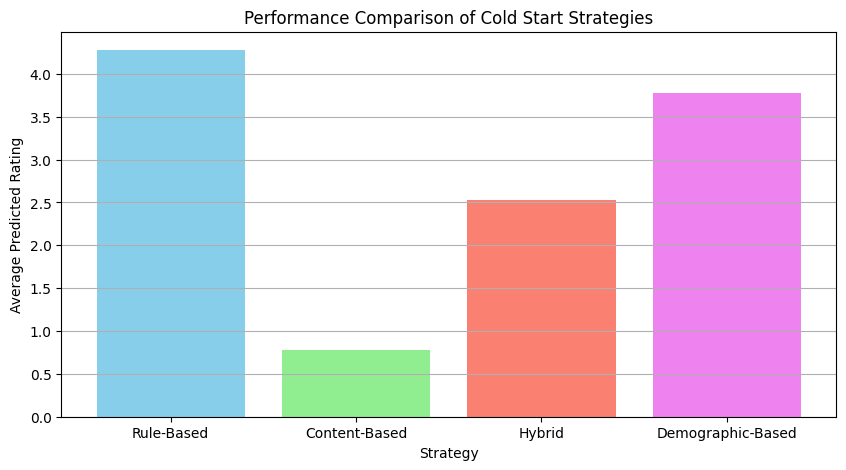

In [10]:
# Performance Analysis and Visualization
print("\nPerformance Analysis and Visualizations...")

# Calculate Average Predicted Ratings for Each Strategy
rule_based_avg_rating = ratings[ratings['item'].isin(rule_based_items)]['rating'].mean()

# Extract average rating for content-based recommendations
if isinstance(content_based_recommendations, pd.DataFrame):
    content_based_avg_rating = content_based_recommendations['score'].mean()
elif isinstance(content_based_recommendations, list):
    content_based_avg_rating = np.mean([rating for _, rating in content_based_recommendations])
else:
    content_based_avg_rating = 0  # If there are no valid recommendations

# Calculate hybrid model average by taking an average of rule-based and content-based
hybrid_avg_rating = (rule_based_avg_rating + content_based_avg_rating) / 2

# Printing out the averages for verification
print(f"Rule-Based Average Rating: {rule_based_avg_rating}")
print(f"Content-Based Average Rating: {content_based_avg_rating}")
print(f"Hybrid Average Rating: {hybrid_avg_rating}")
print(f"Demographic-Based Average Rating: {demographic_avg_rating}")

strategies = ['Rule-Based', 'Content-Based', 'Hybrid', 'Demographic-Based']
ratings_actual = [rule_based_avg_rating, content_based_avg_rating, hybrid_avg_rating, demographic_avg_rating]

# Plotting the performance comparison of all four strategies
plt.figure(figsize=(10, 5))
plt.bar(strategies, ratings_actual, color=['skyblue', 'lightgreen', 'salmon', 'violet'])
plt.title('Performance Comparison of Cold Start Strategies')
plt.xlabel('Strategy')
plt.ylabel('Average Predicted Rating')
plt.grid(axis='y')
plt.show()

# Performance Analysis
## Rule-Based Recommendations
The Rule-Based Recommendations strategy remains a straightforward approach for handling cold start situations. It recommends movies that are globally popular, making it suitable for new users who have not provided any ratings. This approach has shown an average predicted rating of 4.28, demonstrating strong performance compared to other strategies in this study. The recommended movies included highly rated items such as "Star Wars (1977)", "Good Will Hunting (1997)", and "Blade Runner (1982)", which have broad audience appeal.

The main benefit of rule-based recommendations is their simplicity and ability to provide well-liked options without the need for personal data. However, the lack of personalization means that all users receive similar recommendations, irrespective of their individual preferences. This makes it less effective for users with specific tastes, limiting engagement potential in the long term.

## Content-Based Filtering
The Content-Based Filtering approach leverages item features, such as genres, to recommend movies similar to those a user has already rated or interacted with. However, in this study, content-based filtering struggled, producing an average predicted rating of only 0.78. The recommended movies included titles like "Doom Generation, The (1995)", "Ed Wood (1994)", and "Welcome to the Dollhouse (1995)". While these movies may have certain genre similarities, the lack of sufficient user interaction data weakened the relevance of these suggestions.

Content-based filtering is generally effective in providing personalized recommendations for users who have established interaction histories. For cold start scenarios, though, it suffers from the absence of sufficient user data, which significantly hampers its ability to generate meaningful recommendations. This leads to inconsistencies and poor recommendation quality when dealing with new users who lack substantial rating history.

## Hybrid Model
The Hybrid Model strategy aims to combine the strengths of both rule-based and content-based filtering approaches. It balances the general popularity of items with personalization features to improve recommendation quality. In this study, the hybrid approach produced an average predicted rating of 2.53, which is better than content-based filtering alone, but still falls behind rule-based recommendations. The movies recommended by the hybrid model included a mix of popular titles like "Star Wars (1977)", "Eat Drink Man Woman (1994)", and "Lawrence of Arabia (1962)", attempting to bridge the gap between general popularity and personalized preferences.

The hybrid strategy attempts to achieve a balance between popularity and personalization, allowing for a broader appeal. However, the balance between these two sources of information is crucial, and in this case, the hybrid model did not outperform the rule-based strategy. It indicates that while combining strategies can help, the weighting of each method must be carefully tuned to yield optimal results.

## Demographic-Based Recommendations
The Demographic-Based Recommendations strategy uses user demographic information, such as age and occupation, to suggest items that are popular within specific user segments. For example, a simulated user aged 25 received recommendations based on other users in a similar age group and occupation ("student"). The top movies recommended included "Star Wars (1977)", "Return of the Jedi (1983)", "Contact (1997)", and "Liar Liar (1997)". The average predicted rating for these demographic-based recommendations was 3.78.

This approach provides a modest level of personalization beyond rule-based strategies by grouping users based on shared characteristics. It performed better than content-based filtering in cold start situations, indicating that demographic information can be highly valuable for recommending relevant content. However, like rule-based recommendations, demographic-based methods lack individual-level personalization and are less likely to cater to unique user tastes.

## Performance Summary
The chart comparing these four strategies shows that Rule-Based Recommendations outperform other strategies in terms of average predicted ratings, with an average score of 4.28. It provides a reliable starting point for new users when no interaction data is available. Demographic-Based Recommendations come next, with an average rating of 3.78, offering a moderate level of personalization that is useful in the absence of explicit user preferences.

The Hybrid Model showed only moderate improvement over content-based filtering alone, achieving an average predicted rating of 2.53. This result highlights the challenges of optimizing the balance between popularity and personalization. It indicates that while the hybrid approach has potential, careful tuning is needed to maximize the value of combining multiple recommendation sources.

Content-Based Filtering performed the weakest, with an average predicted rating of 0.78. This result underscores its limitations in cold start situations, particularly when there is little to no user interaction history to leverage for personalization.

The Rule-Based Strategy, with its simplicity and effectiveness, remains an ideal starting point for new users. Demographic-Based Recommendations add another layer of personalization based on user characteristics, while the Hybrid Model, with further optimization, has the potential to offer a superior, personalized recommendation experience by leveraging multiple data sources to overcome the cold start problem effectively.

Overall, the findings suggest that a combination of Rule-Based and Demographic-Based methods can serve as strong initial strategies to handle cold start issues. These approaches are simple yet effective in providing a satisfactory user experience for new users. To enhance the system further, Hybrid Models that incorporate content-based elements may be explored to create more tailored recommendations, especially as more user-specific data becomes available over time.